In [19]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
import time
import xarray as xr

import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("notebook") #[poster, paper, talk, notebook]


## functions
STATS

In [20]:
# ~~~~ function, Histogram
def histogram(x, binx):
    '''
    makes histogram for all values >0 in lidar images
    '''

    hist, bin_x = np.histogram(x[x !=0], bins=binx)
    return hist, bin_x[:-1]


# ~~~~ function, Step plot
def step_hist_plt(hist, bin_x, date_iter, axis, line_color, date_label, alpha=0.4, lw=2, shaded=True):
    '''
    computes step plot for histogram values
    '''

    if shaded is True:
      axis.step(bin_x, hist, lw=lw, c=line_color, label = date_label)
      axis.fill_between(bin_x, hist, step="pre", alpha=alpha)

    if shaded is False:
      axis.step(bin_x, hist, lw=lw, c=line_color, label = date_label)
  

# ~~~~ function, Means
def get_mean(x):
    '''
    computes mean snow depth (within basin)
    '''
    
    mu = np.nanmean(x)
    return mu


# ~~~~ function, Standard Deviation
def get_std(x):
    '''
    computes mean snow depth (within basin)
    '''
    
    std = np.nanstd(x)
    return std

PLOTTING

In [111]:
def color_palette(palette_type, flight_count, show_pal=False):
    '''
    This method gives options to the color scheme for line plots

    args:
        palette_type: color scheme [qualitative 'q', sequential 's', diverge 'd']
        flight_count: number of flights to process
        show_pal: see output or not after running option

    '''
    if palette_type is 'q' : #'qualitative' or 'q':
    # qualitative:
        c_pal = sns.color_palette("Dark2", flight_count)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)


    elif palette_type is 's' : #'sequential' or 's':
    # sequential:
        c_pal = sns.color_palette(sns.cubehelix_palette(flight_count, start=.7, rot=-.75,dark=.25, light=.75)) # create color palette (plt.plot(c=c_pal[i]))
        if show_pal==True:
            c_shw = sns.palplot(sns.cubehelix_palette(flight_count, start=.7, rot=-.75,dark=.25, light=.75)) # show colors


    elif palette_type is 'd' : #'diverge' or 'd':
    # diverging:
        c_pal = sns.color_palette("RdBu_r", flight_count)
        if show_pal==True:
            c_shw = sns.palplot(c_pal)

    return c_pal


def make_my_super_plot(ds, title = '', color_scheme = 'q', xlim=[-.01,5]):
    '''
    This method plots a stair step histogram plot for the lidar snow depth data. 
    
        args:
            ds: xarray DataSet in [mm], plots in [cm]
            title: set when you call the function
            color_scheme: qualitative, sequential, or diverge
            xlim: control xlims
            
    '''
    
    d_str = pd.to_datetime(ds['time'].values).strftime("%m-%d-%Y")
#     binx = np.arange(0,2500,1) #(start, stop, step by [cm])
    binx = np.arange(0,10,.01)
    # binx = np.arange(0,250,0.01)

    f=plt.figure(num=0, figsize=(20,10))
    a=plt.gca()
    c_pal = color_palette(color_scheme, ds.time.size)

    with ProgressBar(): #SAVED FIGS FROM HERE
        for i in range(ds.time.size):
            hist, bin_x = xr.apply_ufunc(histogram, ds.snow[i].values, binx, dask='parallelized', output_dtypes=[np.float32])
            step_hist_plt(hist, bin_x, i, a, c_pal[i], d_str[i], alpha=0.2, lw=2, shaded=False)

        a.set_title(title, fontsize='xx-large')
        a.set_xlim(*xlim)
        a.set_xlabel('standardized snow depths', fontsize='xx-large')
        a.set_ylabel('frequency', fontsize='xx-large')
        a.legend(fontsize='xx-large')
        a.tick_params(labelsize='xx-large')
#         a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        plt.grid()
        plt.tight_layout()
        plt.show()

## set up

In [106]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow_20m.nc'
which_year = 2018
peak = False

In [107]:
def standard(x):
    '''
    standardizes the data by each flight by its mean and std
    '''
    a = np.where(x>0, x, np.nan)
    ds_stand = (a-np.nanmean(a))/np.nanstd(a)
    return ds_stand

## main function

In [114]:
def main(fname, which_year, peak=False):

    #ds full
    ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
    ds.close()
    
    #standardize
    ds_stand = xr.apply_ufunc(standard, ds, dask='parallelized', output_dtypes=[np.int16])
    ds=ds_stand
    ds_stand.close()


    if peak:
        #~~~~~~~~~~~ds peak
        dpeak = ds.isel(time=[0,7,18,30,42,49]) 
        dpeak.close()

        ds = dpeak
        ds.close()
        temp_title = 'Standardized snow distribution nearest peak SWE flight date'
        make_my_super_plot(ds,title=temp_title, color_scheme='q')

    else:
        #~~~~~~~~~~~~~~ds small
        dsmall = ds.sel(time='{}'.format(which_year))
        dsmall.close()

        ds = dsmall
        ds.close()
        temp_title = '{} snow depth distribution, binx=1 [cm]'.format(which_year)
        make_my_super_plot(ds,title=temp_title, color_scheme='s', xlim=[0,600])


## call main

[                                        ] | 0% Completed |  0.0s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  3.8s
[#                                       ] | 2% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  4.2s
[#                                       ] | 4% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  4.0s
[#                                       ] | 4% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  3.4s
[##                                      ] | 5% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  3.6s
[#                                       ] | 4% Completed |  0.2s

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[########################################] | 100% Completed |  3.6s


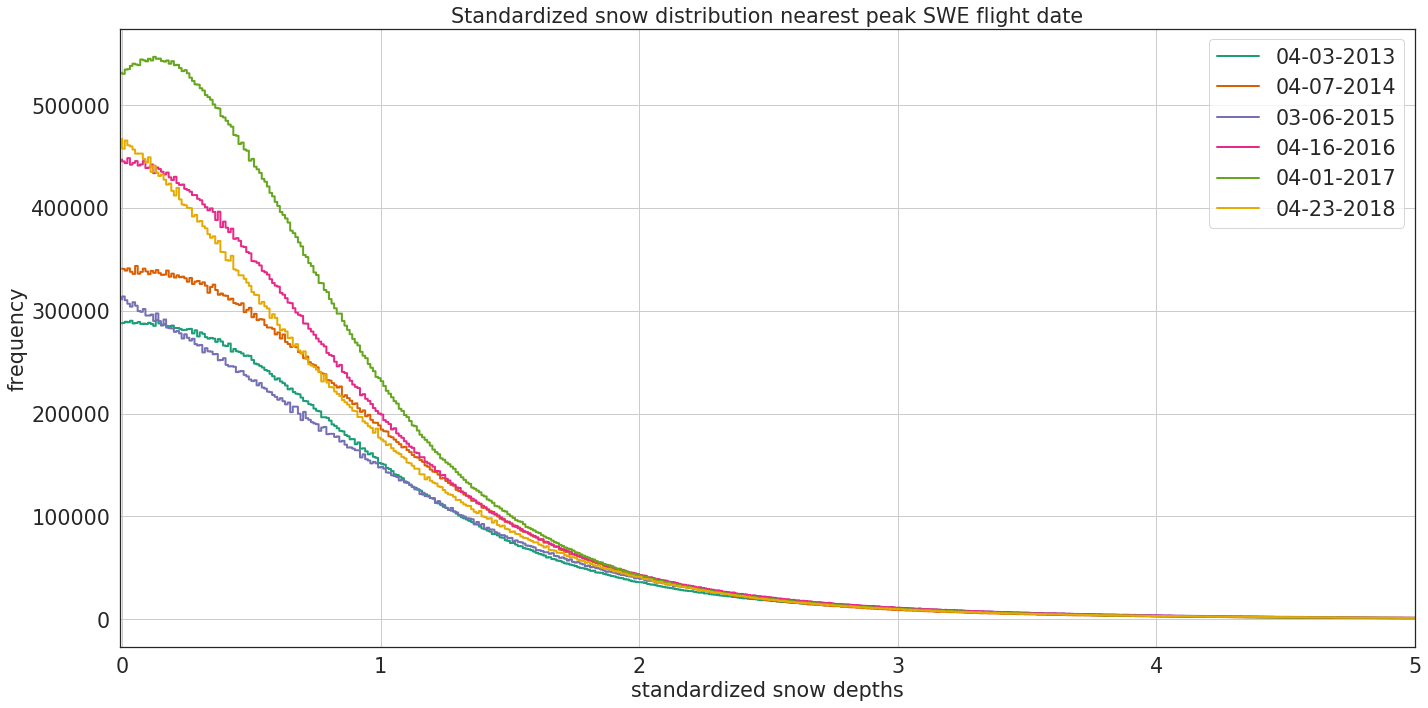

In [116]:
if __name__ == "__main__":
    # for yr in range(2013,2019):
    #     main('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc',yr)


    main('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc',2013, peak=True)

In [67]:
ds = xr.open_dataset(fname)#,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 2637, y: 2739)
Coordinates:
    dem      (y, x) float32 ...
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
    veg      (y, x) float32 ...
    mask     (y, x) uint8 ...
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
Data variables:
    snow     (time, y, x) int16 ...

max snow depth value is: <xarray.DataArray 'snow' ()>
array(6.673446)
Coordinates:
    time     datetime64[ns] 2016-06-20


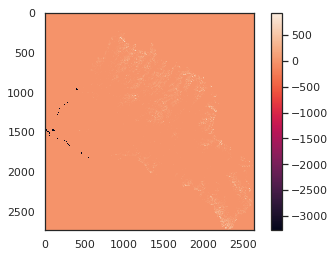

In [78]:
plt.imshow(ds.isel(time=36).snow/10)
print('max snow depth value is:', s.isel(time=36).snow.max())
plt.colorbar()

In [73]:
def standard(x):
    '''
    standardizes the data by each flight by its mean and std
    '''
    a = np.where(x>0, x, np.nan)
    ds_stand = (a-np.nanmean(a))/np.nanstd(a)
    return ds_stand

s = xr.apply_ufunc(standard, ds, dask='parallelized', output_dtypes=[np.int16])

max standardized value is: <xarray.DataArray 'snow' ()>
array(6.673446)
Coordinates:
    time     datetime64[ns] 2016-06-20


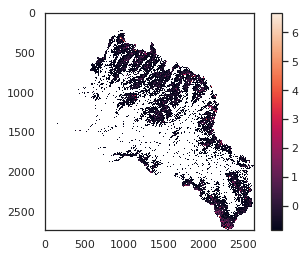

In [74]:
plt.imshow(s.isel(time=36).snow)
print('max standardized value is:', s.isel(time=36).snow.max())
plt.colorbar()